# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [5]:
# from thick_ptycho.sample_space.sample_space import SampleSpace
# from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.simulation.config import SimulationConfig, BoundaryType, ProbeType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver, PWEFullPinTSolver, MSForwardModelSolver
from matplotlib import pyplot as plt
import time

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

2025-11-05 15:30:30,890 - INFO - === Scan Summary (Continuous) ===
2025-11-05 15:30:30,900 - INFO -   Sample space (x-range): 3.000e-07 m
2025-11-05 15:30:30,906 - INFO -   Sample space (z-range): 3.000e-08 m
2025-11-05 15:30:30,921 - INFO -   Probe diameter:         6.000e-09 m
2025-11-05 15:30:30,933 - INFO -   Number of scan points:  60
2025-11-05 15:30:30,940 - INFO -   Steps in z:             20
2025-11-05 15:30:30,946 - INFO -   Detector Pixels:        690
2025-11-05 15:30:30,949 - INFO -   Max Overlap:            3.823e-09 m
2025-11-05 15:30:30,952 - INFO -   Percentage Overlap:     146333333333.33%



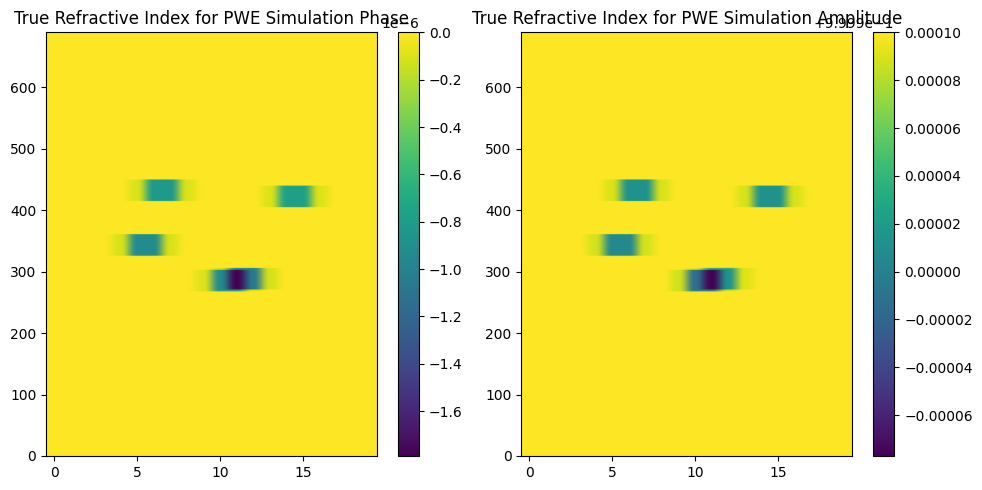

In [6]:
wavelength = 12.4e-9#0.635e-6        # meters (0.635 μm)
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]


# --- Refractive index parameters ---
n_medium = 1.0               # background refractive index

# --- Probe configuration ---
probe_dimensions_discrete = [50]
probe_diameter_scale = 0.02
probe_focus = -5e-6                    # focal length [m]
scan_points = 60
step_size = 5                        # pixels between scans

pad_factor = 2.0  # Portion of extra space to add
# Define margin portion (half of extra space)
pad_margin = (pad_factor - 1) / 2.0

# --- Simulation spatial dimensions (in meters) ---
xlims = [0.0, 300e-9]   # meters (sample width)
zlims = [0.0, 30e-9]   # meters (sample thickness)
continuous_dimensions = (xlims, zlims)

# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
dz = wavelength / 8 
nz = 20 #int(z_range / dz)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), nz)


# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE
probe_type = ProbeType.AIRY_DISK

# --- Create the SimulationConfig object ---
config = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    #probe_angles=(np.linspace(-15,15,3)),
    probe_focus=probe_focus,
    tomographic_projection_90_degree=True,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(config)
simulation_space.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)


# # TODO: Make objects move to the centre with padding or define them in min_nx
# # Add 6 spheres of varying positions
# # Base refractive index offsets
delta = 1e-4
beta = 1e-6

# # Variation strength (fractional)
delta_var = 0.20   # ±20% variation in phase shift
beta_var  = 0.20   # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length = 0.05
common_depth = 0.05
num_circles = 5
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.35, 0.65, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):

    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand  = beta  * (1 + beta_var  * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        'circle',
        refractive_index_perturbation,
        side_length=common_side_length,
        centre=(cx, cz),
        depth=common_depth,
        gaussian_blur=gaussian_blur
    )
ptycho_object.build_field()
# ptycho_object.create_refractive_index_of_phantom(
#     real_perturbation=delta,
#     imaginary_perturbation=beta
# )
simulation_space.viewer.plot_two_panels(ptycho_object.n_true, view="phase_amp",title="True Refractive Index for PWE Simulation")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [7]:
# Solve Full Space Space, Iterative

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(simulation_space,
                                ptycho_object,
                                ptycho_probes)

# Iterative solution
u_pwe = forward_model_pwe.solve()
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=False)

Forward model creation and solving time: 0.13 seconds.



/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


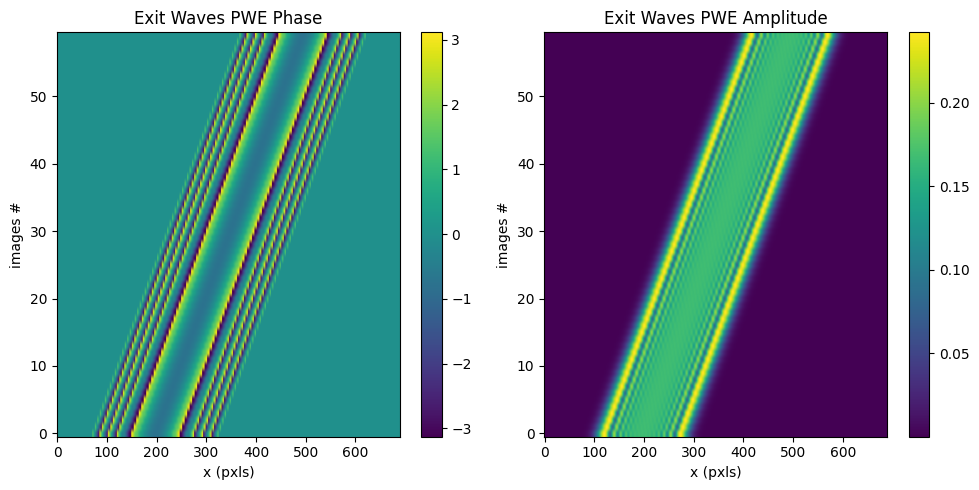

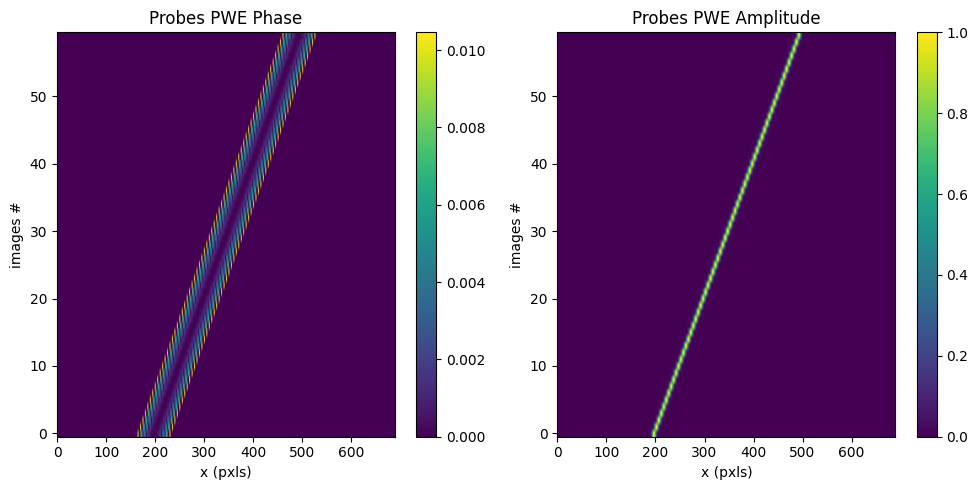

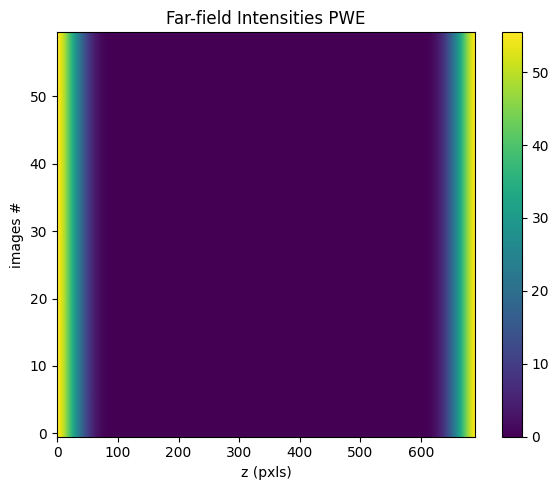

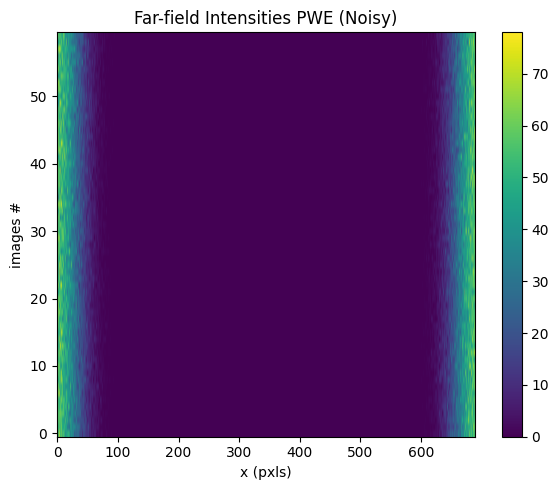

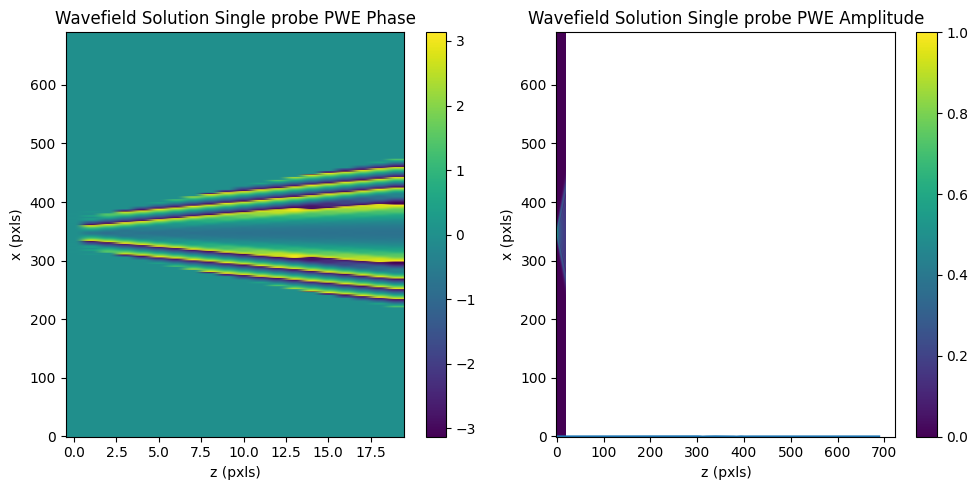

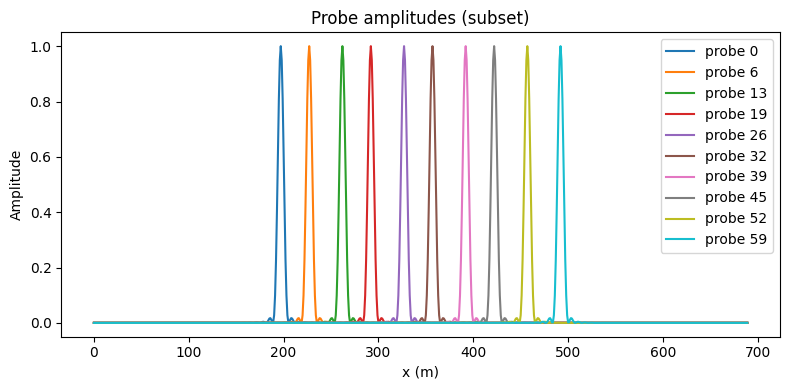

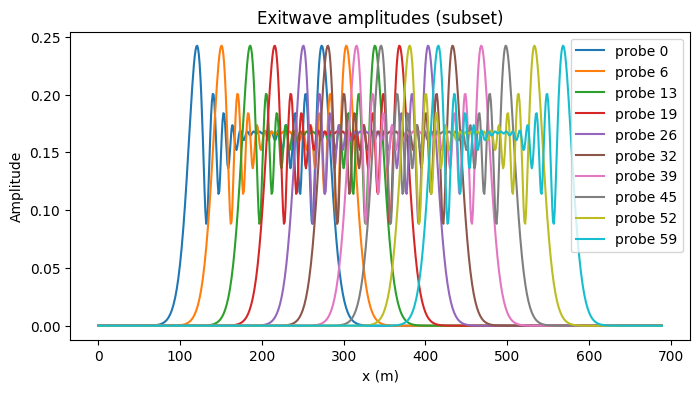

In [8]:
from matplotlib.backends.backend_pdf import PdfPages

simulation_space.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="x (pxls)",
                                        ylabel="images #")

simulation_space.viewer.plot_two_panels(ptycho_probes[0],
                                        view="phase_amp", 
                                        title="Probes PWE",
                                        xlabel="x (pxls)",
                                        ylabel="images #")

simulation_space.viewer.plot_single_panel(intensities_pwe,
                                        title="Far-field Intensities PWE",
                                        xlabel="z (pxls)",
                                        ylabel="images #")

simulation_space.viewer.plot_single_panel(intensities_pwe_noisy,
                                        title="Far-field Intensities PWE (Noisy)",
                                        xlabel="x (pxls)",
                                        ylabel="images #")

# Select Centre Probe
centre_probe_pwe = u_pwe[0,0,simulation_space.num_probes//2, ...]
simulation_space.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution Single probe PWE",
                                        xlabel="z (pxls)",
                                        ylabel="x (pxls)")

plt.plot(range(simulation_space.effective_nx), centre_probe_pwe[:, nz//2])
plt.show()

plt.figure(figsize=(8,4))
plot_num_probes = 10#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.num_probes-1, plot_num_probes, dtype=int)
for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe[0,0,p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x (m)"); plt.ylabel("Amplitude"); plt.legend(); 
plt.tight_layout(); plt.show()

fig = plt.figure(figsize=(8,4))
for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe[0,0,p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x (m)"); plt.ylabel("Amplitude"); plt.legend(); 



### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [9]:
# --- Reconstruction data ---
complex_data = exit_waves_pwe

In [10]:
# Create MS Simulation Space
dz = wavelength*2 # For multi-slice, keep dz larger to reduce number of slices
nz = int(z_range / dz)
discrete_dimensions = (int(min_nx * pad_factor), nz)

# --- Create the SimulationConfig object ---
config_ms = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)
simulation_space_ms = create_simulation_space(config_ms)
simulation_space_ms.summarize()


IndexError: index 1 is out of bounds for axis 0 with size 1

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 77.49948011740165
[Iter 002] Mean Loss = 75.60167099595157
[Iter 003] Mean Loss = 74.59382498571017
[Iter 004] Mean Loss = 73.9063946552546
[Iter 005] Mean Loss = 73.38579352535655
[Iter 006] Mean Loss = 72.96766148692261
[Iter 007] Mean Loss = 72.6188369960537
[Iter 008] Mean Loss = 72.31997962928516
[Iter 009] Mean Loss = 72.05882611349224
[Iter 010] Mean Loss = 71.82711501058559
[Iter 011] Mean Loss = 71.61901844784798
[Iter 012] Mean Loss = 71.4302733735759
[Iter 013] Mean Loss = 71.25766850850354
[Iter 014] Mean Loss = 71.09872546782692
[Iter 015] Mean Loss = 70.95149209131029
[Iter 016] Mean Loss = 70.81440374317656
[Iter 017] Mean Loss = 70.68618742159137
[Iter 018] Mean Loss = 70.5657937534013
[Iter 019] Mean Loss = 70.45234768882294
[Iter 020] Mean Loss = 70.34511205141767
Reconstruction time: 9.93 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

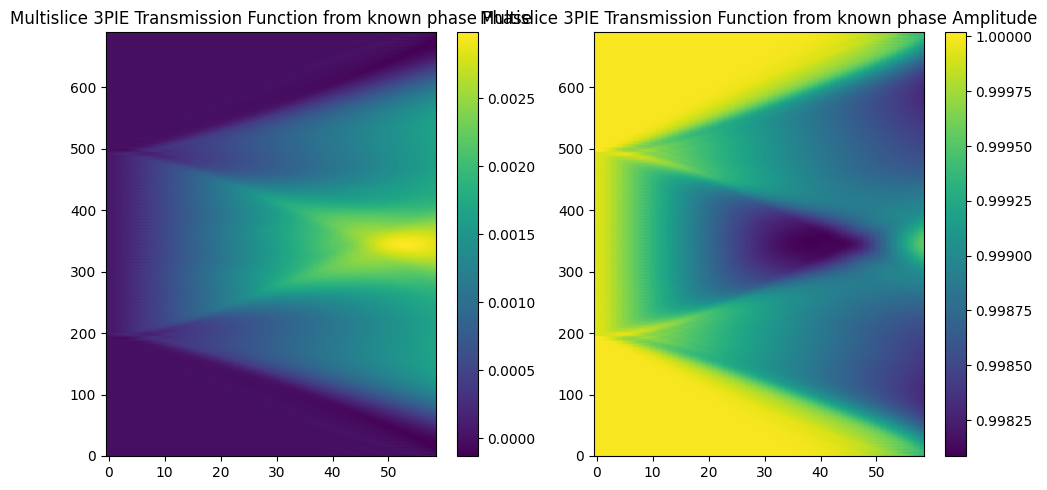

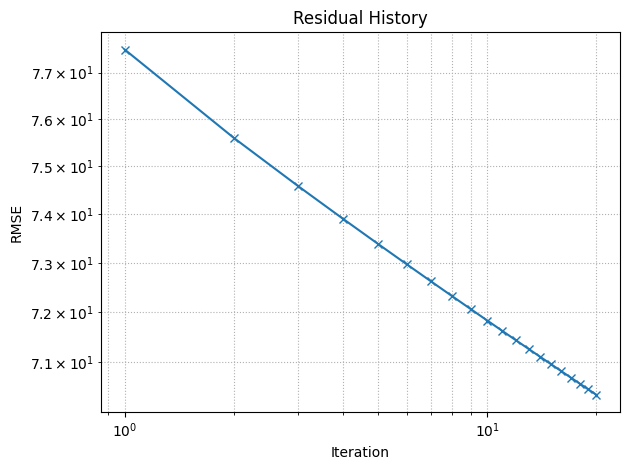

In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
time_start = time.time()
obj_est_ms, residual_ms = recon_ms.reconstruct(max_iters=20,alpha_obj=1e-4, simulate_refractive_index=False)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space_ms.viewer.plot_two_panels(obj_est_ms,title="Multislice 3PIE Transmission Function from known phase",view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, complex_data, phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=5)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

Initializing Least Squares Solver...
Iteration 1/5
    RMSE: 0.0017107168796523598
    Iteration 1 took 24.33 seconds.
Iteration 2/5
    RMSE: 0.0015371852027671266
    Iteration 2 took 21.78 seconds.
Iteration 3/5
    RMSE: 0.0013828011576435125
    Iteration 3 took 21.25 seconds.
Iteration 4/5
    RMSE: 0.0012451826462634788
    Iteration 4 took 20.67 seconds.
Iteration 5/5
    RMSE: 0.0011225769146758124
    Iteration 5 took 20.44 seconds.
Reconstruction time: 108.50 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

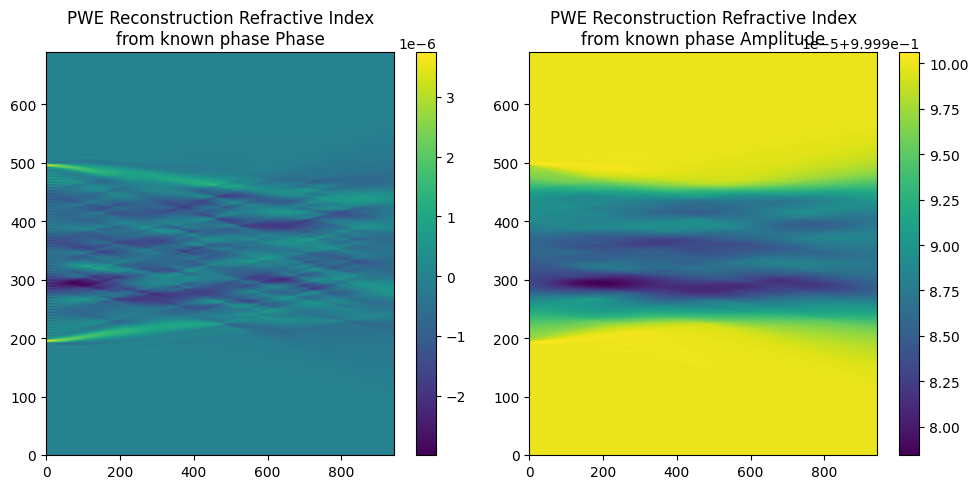

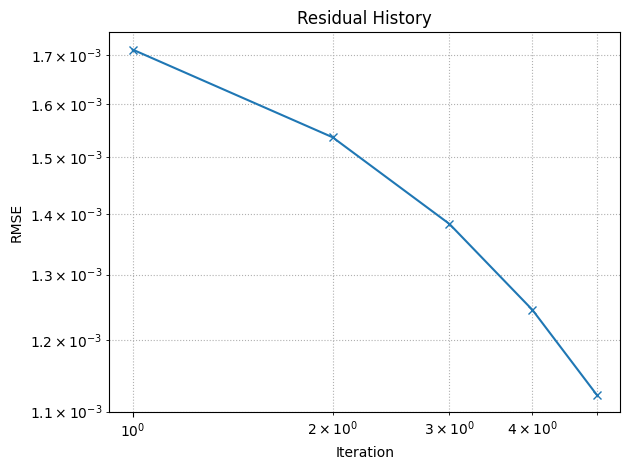

In [ ]:
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp",title=f"PWE Reconstruction Refractive Index\nfrom known phase")
simulation_space.viewer.plot_residual(residual_pwe)

## Phase Retrieval

In [ ]:
# --- Reconstruction data ---
data = intensities_pwe

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.0005014588397673637
[Iter 002] Mean Loss = 0.0005119638111520414
[Iter 003] Mean Loss = 0.0005237484140737618
[Iter 004] Mean Loss = 0.000534353407740004
[Iter 005] Mean Loss = 0.0005438138183110717
[Iter 006] Mean Loss = 0.0005523259561178288
[Iter 007] Mean Loss = 0.000560063351651797
[Iter 008] Mean Loss = 0.0005671606809415
[Iter 009] Mean Loss = 0.0005737218416956291
[Iter 010] Mean Loss = 0.0005798274685335911
[Iter 011] Mean Loss = 0.0005855413095472799
[Iter 012] Mean Loss = 0.0005909144039581526
[Iter 013] Mean Loss = 0.0005959882510778602
[Iter 014] Mean Loss = 0.0006007970758349466
[Iter 015] Mean Loss = 0.0006053693884056113
Reconstruction time: 6.48 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

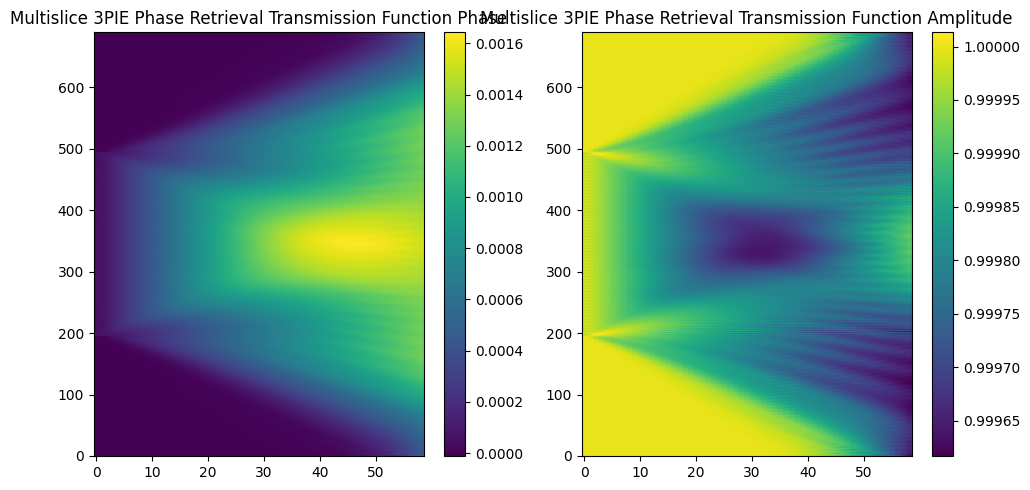

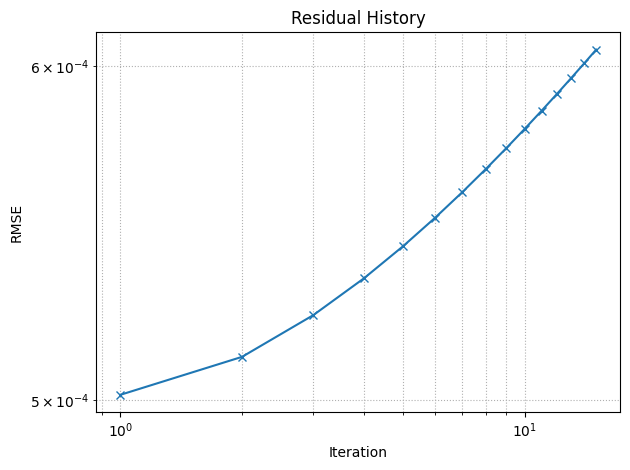

In [ ]:

recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
obj_est_ms_phase_recon, residual_ms = recon_ms.reconstruct(max_iters=15,alpha_obj=1e-4,simulate_refractive_index=False)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(obj_est_ms_phase_recon,view="phase_amp",title="Multislice 3PIE Phase Retrieval Transmission Function")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.00022771715756293566
    Iteration 1 took 19.87 seconds.
Iteration 2/10
    RMSE: 0.0002160868812168731
    Iteration 2 took 20.81 seconds.
Iteration 3/10
    RMSE: 0.00020540067695832076
    Iteration 3 took 19.55 seconds.
Iteration 4/10
    RMSE: 0.00019568618712547818
    Iteration 4 took 17.04 seconds.
Iteration 5/10
    RMSE: 0.00018685532546853256
    Iteration 5 took 16.62 seconds.
Iteration 6/10
    RMSE: 0.00017882248675062145
    Iteration 6 took 19.01 seconds.
Iteration 7/10
    RMSE: 0.00017150902283327807
    Iteration 7 took 33.23 seconds.
Iteration 8/10
    RMSE: 0.00016484306813911836
    Iteration 8 took 19.80 seconds.
Iteration 9/10
    RMSE: 0.00015875921586763032
    Iteration 9 took 20.60 seconds.
Iteration 10/10
    RMSE: 0.00015319816684150617
    Iteration 10 took 21.32 seconds.
Reconstruction time: 207.94 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

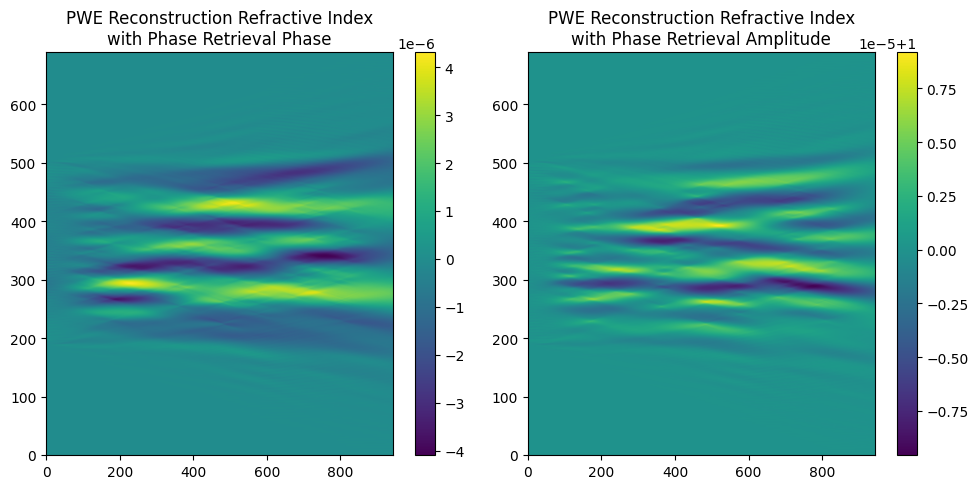

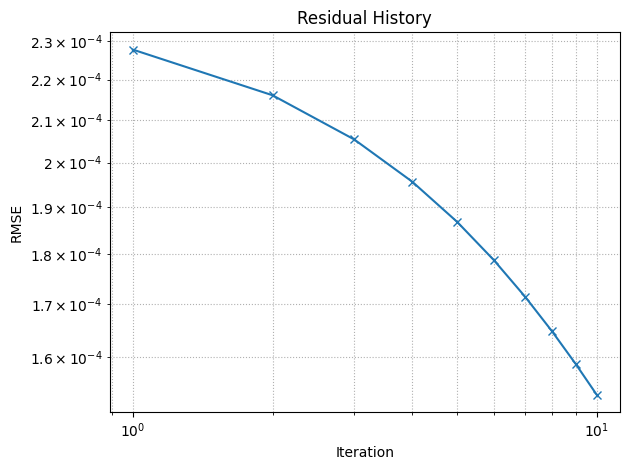

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp",title=f"PWE Reconstruction Refractive Index\nwith Phase Retrieval")
simulation_space.viewer.plot_residual(residual_pwe)

# Phase Retrieval (noisy data)

In [ ]:
rng = np.random.default_rng(seed=42)

data = rng.poisson(intensities_pwe) 


Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.014227409757400207
[Iter 002] Mean Loss = 0.014191825358777065
[Iter 003] Mean Loss = 0.014180163916621046
[Iter 004] Mean Loss = 0.014175095858379437
[Iter 005] Mean Loss = 0.014172824491016197
[Iter 006] Mean Loss = 0.014171991027874
[Iter 007] Mean Loss = 0.014171975455578138
[Iter 008] Mean Loss = 0.014172461322614975
[Iter 009] Mean Loss = 0.014173264249491165
[Iter 010] Mean Loss = 0.014174276952681029
[Iter 011] Mean Loss = 0.014175426962331771
[Iter 012] Mean Loss = 0.01417667038087098
[Iter 013] Mean Loss = 0.014177973575914394
[Iter 014] Mean Loss = 0.014179316649801234
[Iter 015] Mean Loss = 0.014180680397236928
Reconstruction time: 7.98 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

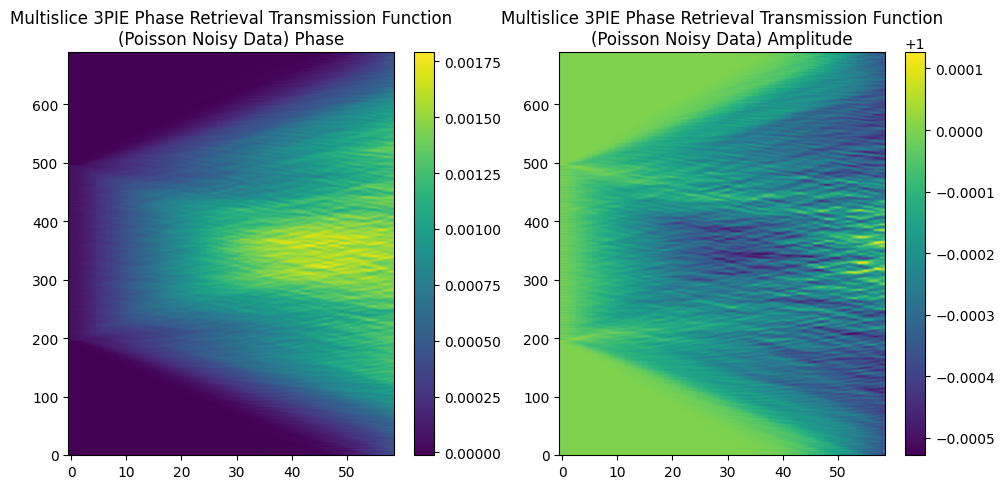

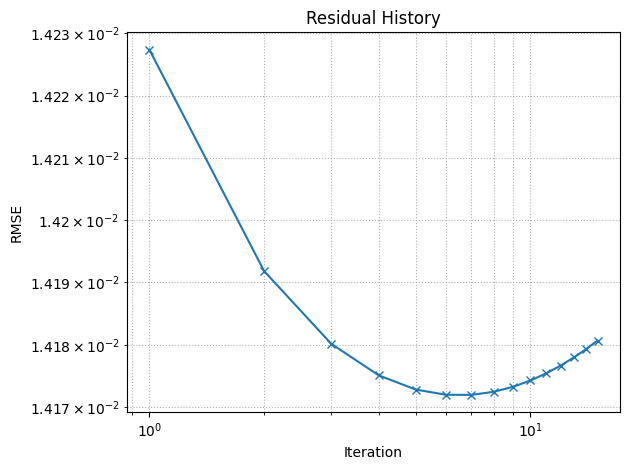

In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=15,alpha_obj=1e-4,simulate_refractive_index=False)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp",title=f"Multislice 3PIE Phase Retrieval Transmission Function\n(Poisson Noisy Data)")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=20)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp",title=f"PWE Reconstruction Refractive Index\nwith Phase Retrieval from noisy data")
simulation_space.viewer.plot_residual(residual_pwe)

Initializing Least Squares Solver...
Iteration 1/20
    RMSE: 0.010206664522455899
    Iteration 1 took 19.42 seconds.
Iteration 2/20
    RMSE: 0.010171072048805992
    Iteration 2 took 20.21 seconds.
Iteration 3/20
    RMSE: 0.010141387669951915
    Iteration 3 took 21.37 seconds.
Iteration 4/20
    RMSE: 0.010112300164549814
